In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

In [2]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

W&B disabled.


In [3]:
INPUT_DIR = 'css-data'
WORK_DIR = 'working'

In [4]:
num_classes = 10
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [5]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [6]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

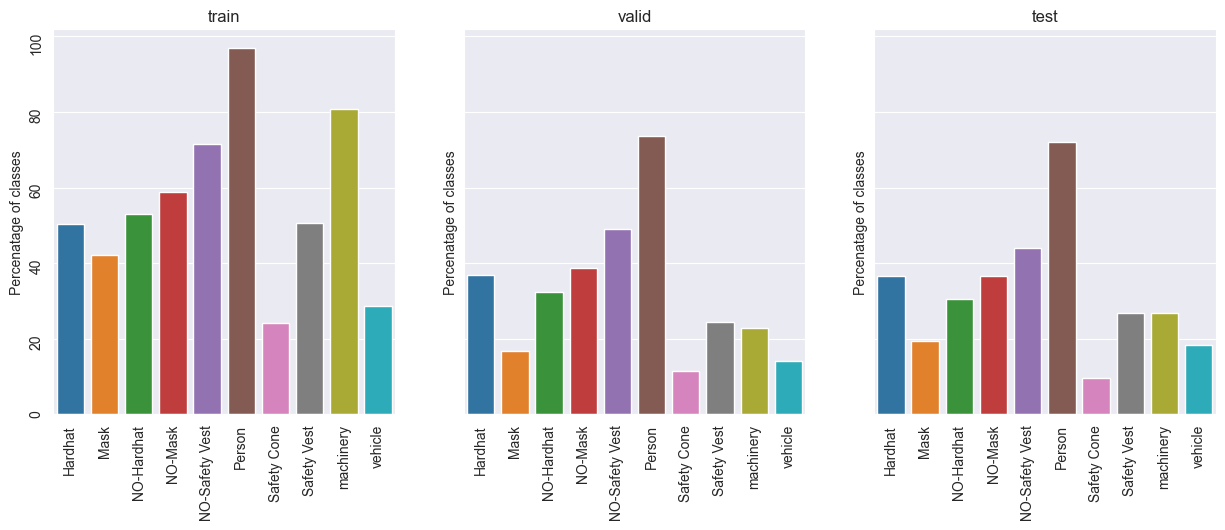

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [8]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [9]:
for mode in ['train', 'valid', 'test']:

    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



In [10]:
model = YOLO('yolov8n.pt')

In [12]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=3,
            batch=8,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics YOLOv8.0.128 🚀 Python-3.9.6 torch-2.0.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=working/data.yaml, epochs=3, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=

KeyboardInterrupt: 

In [17]:
model = YOLO('runs/detect/yolov8n_v1_train_30_epochs/weights/best.pt')

# Detect images

In [18]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 machinery, 93.7ms
image 2/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 1 NO-Hardhat, 1 NO-Mask, 1 machinery, 82.6ms
image 3/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 4 Persons, 74.9ms
image 4/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Person, 1 Safety Cone, 67.3ms
image 5/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 5 NO-Safety Vests, 6 Persons, 1 Safety Vest, 71.5ms
image 6/82 /Users/Jabez/PycharmProjects/safety/notebook/css-data/test/images/004763_jpg.rf

82


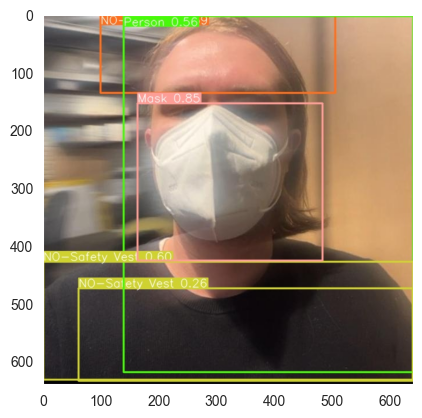

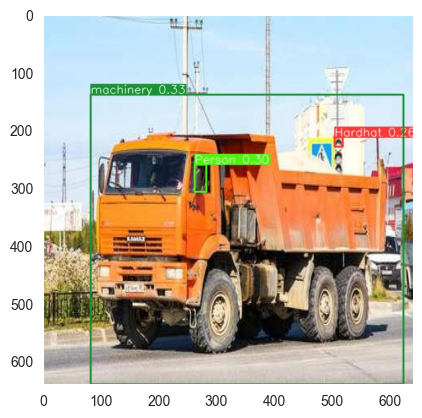

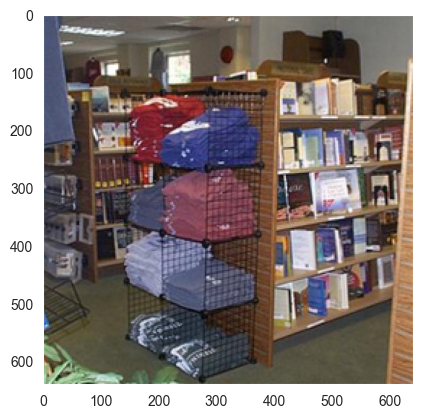

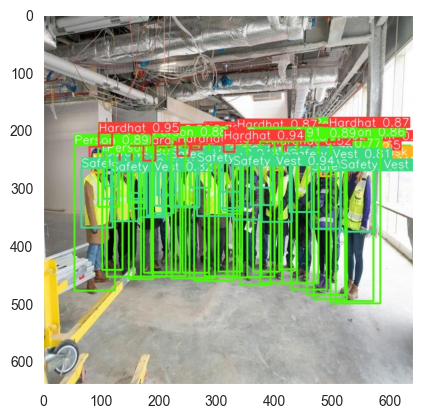

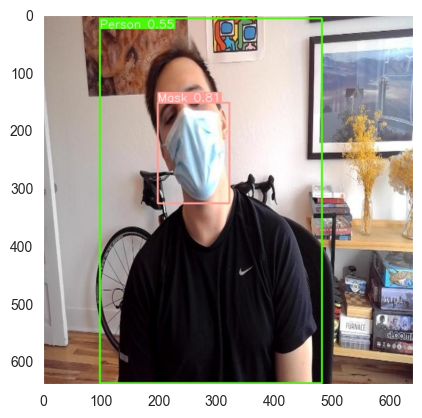

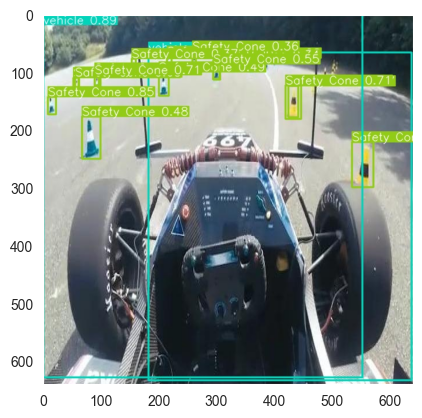

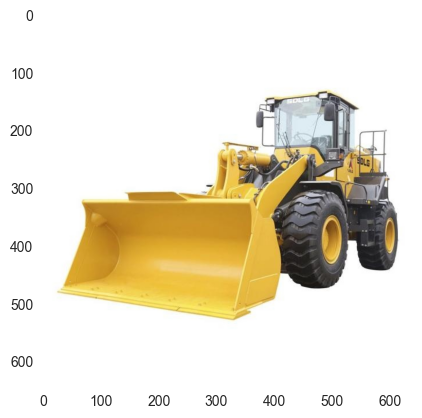

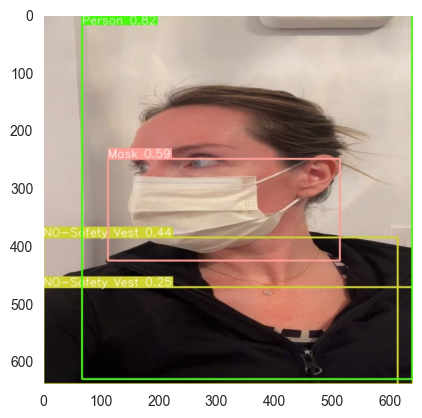

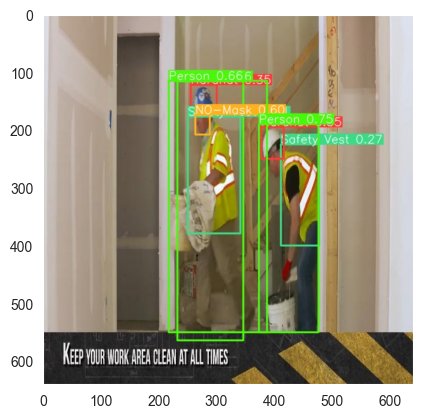

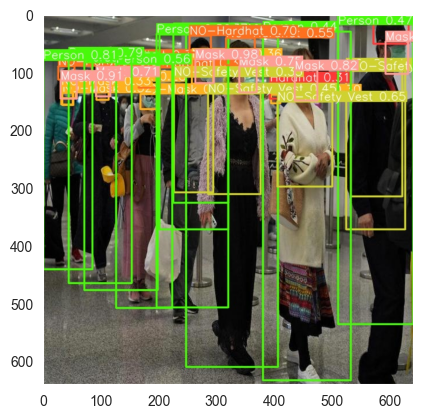

In [12]:
%matplotlib inline

predicitions = glob.glob(os.path.join('./', 'runs/detect/predict', '*'))

print(len(predicitions))
n = 10

for i in range(n):
    # idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[i])
    plt.imshow(image)
    plt.grid(False)
    plt.show()


# Detect from webcam

In [ ]:
import os
import cv2

INPUT_DIR = 'css-data'

# results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)
results = model.predict(source=0, show=True)
cv2.destroyAllWindows()
for i in range(4):
    cv2.waitKey(1)
